In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np

import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import glob
from tqdm import tqdm
from collections import OrderedDict, defaultdict
from IPython.display import clear_output
import time
import os

In [2]:
fn='source_images3/jump_03-02-12-34-01-795/00012.jpg'

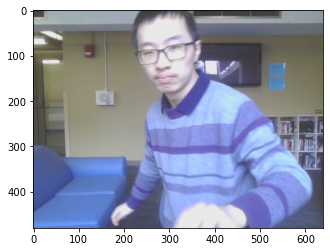

In [3]:
img = cv2.imread(fn) 

image_rgb=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)

In [7]:
# plt.imshow(img)

In [4]:
pose = mp.solutions.pose.Pose(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5)

results = pose.process(image_rgb)
landmarks=results.pose_landmarks.landmark

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [5]:
def draw_points(image, landmarks, keys=None):
    mp_drawing = mp.solutions.drawing_utils
    drawing_spec = mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=2)
 
    if keys==None: keys=[ i for i in range(len(landmarks)) ]
     
    for key in keys:
        landmark_point = landmarks[key]
        x_px, y_px = int(landmark_point.x * image.shape[1]), int(landmark_point.y * image.shape[0])
        cv2.circle(image, (x_px, y_px), drawing_spec.circle_radius, drawing_spec.color, drawing_spec.thickness)
    return image 

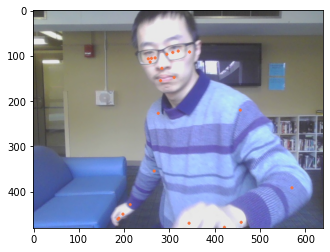

In [6]:
keys=[9,10,11,12,15,16]
image=draw_points(image_rgb.copy(), landmarks, keys=None)
plt.imshow(image)

In [7]:
xys=[]
for landmark in landmarks:
    xys.append([landmark.x, landmark.y])
xys=np.array(xys)
xys.shape

(33, 2)

In [8]:
pose = mp.solutions.pose.Pose(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5)
def extract_keypoints(image_rgb): 
    try:
        results = pose.process(image_rgb)
        landmarks=results.pose_landmarks.landmark
    except Exception as e:
        # print('Error file=', fn)
        # print('Error=', e)
        return None
    xys=[]
    for landmark in landmarks:
        xys.append([landmark.x, landmark.y])
    xys=np.array(xys)
    return xys

In [9]:
# xys=extract_keypoints(image_rgb)
# xys.shape

In [18]:
dir='source_images3/'
activity='jump_03-02-12-34-01-795'
nfn=580

jump1=[]
skipped=0
for i in tqdm(range(1,nfn+1), desc='Extracing Keypoints'):
    fn=f'{dir}{activity}/{i:05d}.jpg' 
    # print('fn=',fn)
    
    img = cv2.imread(fn) 
    image_rgb=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    tried=0
    for i in range(5):
        xys=extract_keypoints(image_rgb)
        if xys is not None: break  
    
    if tried>max_tried:
        max_tried=tried

    if xys is None:
        skipped+=1
        continue
    else:
        xys=xys.ravel()

    jump1.append(xys)

Extracing Keypoints: 100%|██████████| 580/580 [00:49<00:00, 11.60it/s]


In [38]:
def load_and_extract_kps(dir, activity, nfn):
    jump1=[]
    skipped=[]
    max_tried=0
    for i in tqdm(range(1,nfn+1), desc='Extracing Keypoints'):
        fn=f'{dir}{activity}/{i:05d}.jpg' 
        # print('fn=',fn)
        
        img = cv2.imread(fn) 
        image_rgb=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        tried=0
        for i in range(10):
            tried+=1
            xys=extract_keypoints(image_rgb)
            if xys is not None: break  
        
        if tried>max_tried:
            max_tried=tried

        if xys is None:
            skipped.append(fn)
            continue
        else:
            xys=xys.ravel()

        jump1.append(xys)
    return jump1, skipped, max_tried

In [34]:
dir='source_images3/'
activity='jump_03-02-12-34-01-795'
nfn=580
jump1,skipped, max_tried=load_and_extract_kps(dir, activity, nfn)
jump1=np.array(jump1)
print(jump1.shape, skipped, max_tried)

tosave='kps/'+activity+'.txt'
print('Saving to ', tosave)
np.savetxt(tosave, jump1, fmt='%.8f')

Extracing Keypoints: 100%|██████████| 580/580 [00:49<00:00, 11.66it/s]


((580, 66), 0, 1)

Saving to  kps/jump_03-02-12-34-01-795.txt


In [41]:
dir='source_images3/'
activity='jump_03-12-09-18-26-176'
nfn=726
jump1,skipped, max_tried=load_and_extract_kps(dir, activity, nfn)
jump1=np.array(jump1)
print(jump1.shape, len(skipped), max_tried)

tosave='kps/'+activity+'.txt'
print('Saving to ', tosave)
np.savetxt(tosave, jump1, fmt='%.8f')

Extracing Keypoints: 100%|██████████| 726/726 [01:09<00:00, 10.41it/s]

(715, 66) 11 10
Saving to  kps/jump_03-12-09-18-26-176.txt


In [42]:
skipped

['source_images3/jump_03-12-09-18-26-176/00001.jpg',
 'source_images3/jump_03-12-09-18-26-176/00002.jpg',
 'source_images3/jump_03-12-09-18-26-176/00003.jpg',
 'source_images3/jump_03-12-09-18-26-176/00004.jpg',
 'source_images3/jump_03-12-09-18-26-176/00005.jpg',
 'source_images3/jump_03-12-09-18-26-176/00006.jpg',
 'source_images3/jump_03-12-09-18-26-176/00007.jpg',
 'source_images3/jump_03-12-09-18-26-176/00008.jpg',
 'source_images3/jump_03-12-09-18-26-176/00009.jpg',
 'source_images3/jump_03-12-09-18-26-176/00010.jpg',
 'source_images3/jump_03-12-09-18-26-176/00726.jpg']

### extract action segments based on valid_images.txt

In [46]:
meta_fn='source_images3/valid_images.txt'
with open(meta_fn) as f:
    valid_images=f.readlines()

info=[line.strip() for line in valid_images]

In [62]:
datas=defaultdict(list)
activity=None
for line in info:
    if '_' in line:
        activity=line
    elif line=='':
        continue
    else:
        s,e=line.split()
        s,e=int(s), int(e)
        datas[activity].append( (s,e) )


In [65]:
for key in datas:
    print(key, len(datas[key]))
print('---')

jump_03-02-12-34-01-795 16
jump_03-12-09-18-26-176 1
jump_03-13-11-27-50-720 1
kick_03-02-12-36-05-185 18
kick_03-08-20-32-41-586 2
kick_03-12-09-23-41-176 1
kick_03-13-16-18-12-361 4
punch_03-12-09-21-27-876 1
run_03-02-12-31-47-095 1
run_03-12-09-15-25-375 1
sit_03-02-12-27-51-085 1
sit_03-02-12-28-32-893 1
sit_03-12-09-25-43-527 1
sit_03-13-16-15-56-861 15
squat_03-08-20-26-57-195 1
squat_03-13-13-21-48-761 1
stand_03-08-20-24-55-587 1
stand_03-08-20-35-06-287 1
stand_03-12-09-17-05-376 2
stand_03-13-13-22-37-869 1
walk_03-12-09-13-10-875 1
walk_03-02-12-30-23-393 1
wave_03-08-20-28-39-387 1
wave_03-13-13-23-25-262 1
---


In [74]:
for key in datas:
    segments=datas[key] 
    for s,e in segments:
        se=f'{s:03d}-{e:03d}'
        print(key, s,e, se)
    break

jump_03-02-12-34-01-795 52 59 052-059
jump_03-02-12-34-01-795 72 79 072-079
jump_03-02-12-34-01-795 114 121 114-121
jump_03-02-12-34-01-795 134 141 134-141
jump_03-02-12-34-01-795 161 169 161-169
jump_03-02-12-34-01-795 181 188 181-188
jump_03-02-12-34-01-795 236 245 236-245
jump_03-02-12-34-01-795 276 284 276-284
jump_03-02-12-34-01-795 313 321 313-321
jump_03-02-12-34-01-795 331 338 331-338
jump_03-02-12-34-01-795 349 356 349-356
jump_03-02-12-34-01-795 367 374 367-374
jump_03-02-12-34-01-795 385 392 385-392
jump_03-02-12-34-01-795 403 409 403-409
jump_03-02-12-34-01-795 424 428 424-428
jump_03-02-12-34-01-795 441 541 441-541


In [101]:
dir='source_images3/'
def view_activity(activity_fn, s,e, delay=0.2):
    fn=dir+activity_fn
    for i in range(s,e+1):
        fni=f'{fn}/{i:05d}.jpg'
        img=cv2.imread(fni)
        img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img) 
        plt.show()
        time.sleep(delay)
        clear_output(wait=True)

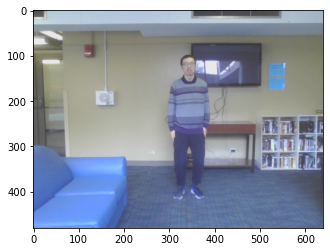

In [102]:
activity_fn='jump_03-02-12-34-01-795'
view_activity(activity_fn, 52, 59)

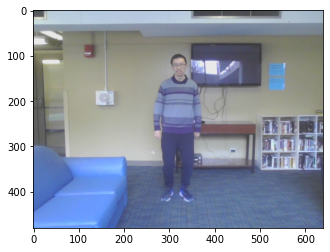

In [103]:
activity_fn='jump_03-02-12-34-01-795'
view_activity(activity_fn, 441, 541)

In [81]:
dir='source_images3/'
def action_segment_extract_kps(activity_fn, start_i, end_i):
    jump1=[]
    for i in range(start_i,end_i+1):
        fn=f'{dir}{activity_fn}/{i:05d}.jpg' 
        # print('fn=',fn)
        
        img = cv2.imread(fn) 
        image_rgb=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        xys=extract_keypoints(image_rgb)
        xys=xys.ravel()

        jump1.append(xys)
    return np.array(jump1)

In [86]:
activity_fn='jump_03-02-12-34-01-795'
action=action_segment_extract_kps(activity_fn, 52, 59)
action.shape

(8, 66)

In [118]:
for action_fn in tqdm(datas):
    segments=datas[action_fn] 
    action_name=action_fn.split('_')[0]
    for s,e in segments:
        se=f'{s:03d}-{e:03d}'
        d=e-s+1

        try:
            action=action_segment_extract_kps(action_fn, s, e)
            todir='kps/'+action_fn
            if not os.path.exists(todir): os.makedirs(todir)
            tosave=todir+'/'+action_name+'_'+se+'_'+str(d)+'.txt'
            # print(key, se, action.shape, d, tosave)
            np.savetxt(tosave, action, fmt='%.8f')
        except:         
            print('error', action_fn, se) 
        # break

    # break

 71%|███████   | 17/24 [10:08<03:29, 29.99s/it]

error stand_03-08-20-24-55-587 055-520


100%|██████████| 24/24 [16:12<00:00, 40.54s/it]


In [117]:
action_fn, se

('stand_03-08-20-24-55-587', '055-520')